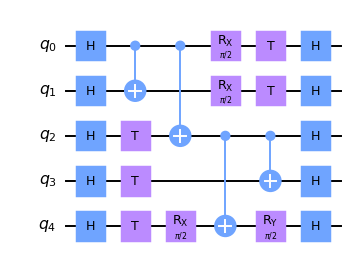

In [1]:
import unittest

import sys
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.result import ProbDistribution
import sys
sys.path.append("/home/symba/_dev/quantum-computing/circuit-knitting-toolbox/")
import json

from circuit_knitting_toolbox.circuit_cutting.wire_cutting import (
    cut_circuit_wires,
    evaluate_subcircuits,
    reconstruct_full_distribution,
    verify,
)
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Options,
)


num_qubits = 8
num_qubits = 5

circuit = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    circuit.h(i)
circuit.cx(0, 1)
for i in range(2, num_qubits):
    circuit.t(i)
circuit.cx(0, 2)
circuit.rx(np.pi / 2, 4)
circuit.rx(np.pi / 2, 0)
circuit.rx(np.pi / 2, 1)
circuit.cx(2, 4)
circuit.t(0)
circuit.t(1)
circuit.cx(2, 3)
circuit.ry(np.pi / 2, 4)
for i in range(num_qubits):
    circuit.h(i)

circuit.draw("mpl", fold=-1, scale=0.7)


In [5]:

cuts = cut_circuit_wires(
    circuit=circuit,
    method="manual",
    subcircuit_vertices=[[0,1],[2,3]]
    #max_subcircuit_width=5,
    #max_cuts=2,
    #num_subcircuits=[2],
)

--------------------
subcircuit 0
ρ qubits = 0, O qubits = 1, width = 3, effective = 2, depth = 6, size = 12
     ┌───┐                     ┌─────────┐┌───┐┌───┐
q_0: ┤ H ├──■───────────────■──┤ Rx(π/2) ├┤ T ├┤ H ├
     ├───┤┌─┴─┐┌─────────┐  │  └──┬───┬──┘├───┤└───┘
q_1: ┤ H ├┤ X ├┤ Rx(π/2) ├──┼─────┤ T ├───┤ H ├─────
     ├───┤├───┤└─────────┘┌─┴─┐   └───┘   └───┘     
q_2: ┤ H ├┤ T ├───────────┤ X ├─────────────────────
     └───┘└───┘           └───┘                     
subcircuit 1
ρ qubits = 1, O qubits = 0, width = 3, effective = 3, depth = 6, size = 11
                                          ┌───┐
q_0: ───────────────────────■───────■─────┤ H ├
     ┌───┐┌───┐             │     ┌─┴─┐   ├───┤
q_1: ┤ H ├┤ T ├─────────────┼─────┤ X ├───┤ H ├
     ├───┤├───┤┌─────────┐┌─┴─┐┌──┴───┴──┐├───┤
q_2: ┤ H ├┤ T ├┤ Rx(π/2) ├┤ X ├┤ Ry(π/2) ├┤ H ├
     └───┘└───┘└─────────┘└───┘└─────────┘└───┘
Estimated cost = 1.280e+02
--------------------


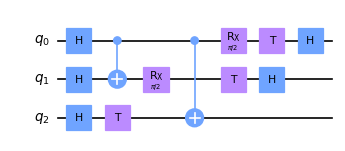

In [4]:
cuts["subcircuits"][0].draw("mpl", fold=-1, scale=0.6)

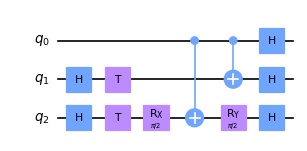

In [3]:
cuts["subcircuits"][1].draw("mpl", fold=-1, scale=0.6)


subcircuit_instance_probabilities
{0: {0: array([0.64016504, 0.21338835, 0.10983496, 0.03661165]), 3: array([-1.66533454e-16,  4.16333634e-17, -2.77555756e-17,  6.93889390e-18]), 1: array([ 6.03553391e-01, -6.93889390e-17,  1.03553391e-01,  6.93889390e-18]), 2: array([ 0.21338835, -0.21338835,  0.03661165, -0.03661165])}, 1: {0: array([0.3642767, 0.3642767, 0.0625   , 0.0625   , 0.0625   , 0.0625   ,
       0.0107233, 0.0107233]), 1: array([0.0625   , 0.0625   , 0.0107233, 0.0107233, 0.3642767, 0.3642767,
       0.0625   , 0.0625   ]), 2: array([0.3642767, 0.0625   , 0.0107233, 0.0625   , 0.3642767, 0.0625   ,
       0.0107233, 0.0625   ]), 3: array([0.21338835, 0.21338835, 0.03661165, 0.03661165, 0.21338835,
       0.21338835, 0.03661165, 0.03661165])}}

metrics!
{'nearest': {'chi2': 0, 'Mean Squared Error': 2.0143763433950126e-32, 'Mean Absolute Percentage Error': 6.589822754723403e-14, 'Cross Entropy': 2.599681088367844, 'HOP': 0.9004283905932714}, 'naive': {'chi2': 0, 'Mean Square

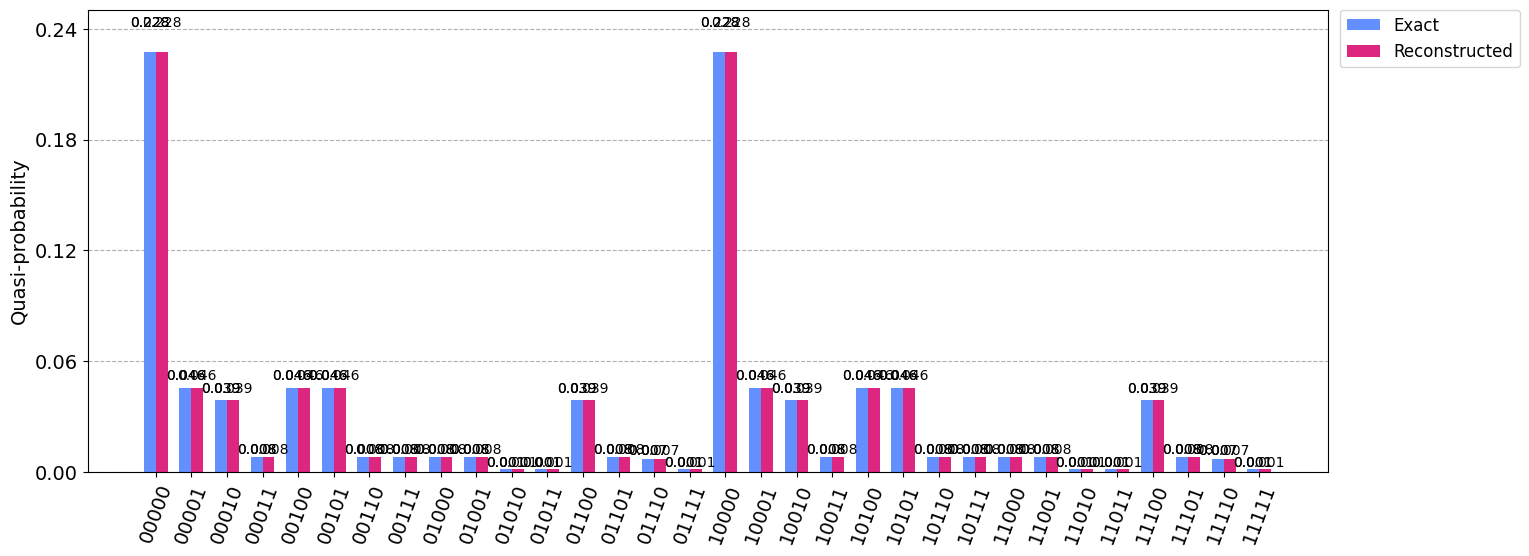

In [6]:

options = Options(execution={"shots": 4000})

subcircuit_instance_probabilities = evaluate_subcircuits(cuts,service=None, backend_names=None, options=options)
print("\nsubcircuit_instance_probabilities")
print(subcircuit_instance_probabilities)

reconstructed_probabilities = reconstruct_full_distribution(
    circuit, subcircuit_instance_probabilities, cuts
)
metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)
print("\nmetrics!")
print(metrics)

# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

print("\nreconstructed_distribution")
print(reconstructed_distribution)

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)

print("\nreconstructed_dict_bitstring")
print(reconstructed_dict_bitstring)

# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)

print("\nexact_dict_bitstring")
print(exact_dict_bitstring)

# plot a histogram of the distributions
plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
#     number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)